In [1]:
import os

import h5py
import himalaya.scoring
import numpy as np
import pandas as pd
from himalaya.backend import set_backend
from himalaya.ridge import RidgeCV
from matplotlib import pyplot as plt
import seaborn as sns
import simplstyles
from scipy.stats import zscore
from sklearn.pipeline import make_pipeline
from voxelwise_tutorials.delayer import Delayer
from voxelwise_tutorials.io import load_hdf5_array

from fmri.features import load_brain_data, load_feature

In [2]:
backend = set_backend("torch_cuda", on_error='throw')
plt.style.use('nord-light-talk')
data_dir = "../../data"

In [3]:
subject = 1
modality = "reading"
trim = 5

In [4]:
n_alphas_batch = 3
n_targets_batch = 100
n_targets_batch_refit = 50

In [5]:
number_of_delays = 4
cv = 5

In [6]:
def result_path(subject, modality, ridge_type, param_name, param_range):
    dir = f"results/brain_maps_validation_curves/{modality}/{subject}/{ridge_type}"
    os.makedirs(dir, exist_ok=True)
    path = os.path.join(dir, f"{param_name}_{param_range}.csv")
    return path

# Load features

In [7]:
X, n_samples_train = load_feature(data_dir, "english1000")

# Load brain data

In [8]:
Y, n_samples_train = load_brain_data(data_dir, subject, modality, trim)

/home/leo/PycharmProjects/compare_variance_residual/compare_variance_residual/fmri/features.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  Y_train = np.vstack([zscore(Y_train[story][:-trim]) for story in Y_train.keys()])
/home/leo/PycharmProjects/compare_variance_residual/compare_variance_residual/fmri/features.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  Y_train = np.vstack([zscore(Y_train[story][:-trim]) for story in Y_train.keys()])
/home/leo/PycharmProjects/compare_variance_residual/compare_variance_residual/fmri/features.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  Y_train = np.vstack(

# Alphas

In [9]:
alpha_range = np.logspace(-5, 30, 6)
alpha_range

array([1.e-05, 1.e+02, 1.e+09, 1.e+16, 1.e+23, 1.e+30])

In [10]:
path = result_path(subject, modality, "ridge", "alpha", alpha_range)

In [11]:
if not os.path.exists(path):
    print("File does not exist")
    delayer = Delayer(delays=range(1, number_of_delays + 1))

    solver_params = dict(
        n_targets_batch=n_targets_batch,
        n_targets_batch_refit=n_targets_batch_refit,
        n_alphas_batch=n_alphas_batch,
        score_func=himalaya.scoring.r2_score
    )
    ridge_cv = RidgeCV(alphas=alpha_range, cv=cv, solver_params=solver_params)
    pipeline = make_pipeline(
        delayer,
        ridge_cv
    )

    pipeline.fit(X[:n_samples_train], Y[:n_samples_train])

    score = pipeline.score(X[n_samples_train:], Y[n_samples_train:])

    best_alphas = pd.DataFrame(
        {
            'best_alphas': backend.to_numpy(pipeline[-1].best_alphas_),
            'score': backend.to_numpy(score)
        }
    )
    best_alphas.to_csv(path)
else:
    print("File exists")
    best_alphas = pd.read_csv(path)

File exists


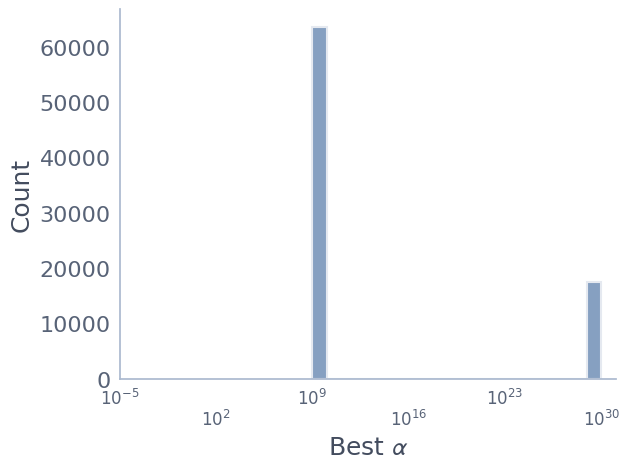

In [12]:
fig, ax = plt.subplots()
sns.histplot(best_alphas['best_alphas'], bins=20, log_scale=True, ax=ax)
plt.xlabel(r"Best $\alpha$")
plt.xticks(alpha_range)
labels_formatted = [label.get_text() if i % 2 == 0 else '\n' + label.get_text() for i, label in
                    enumerate(ax.xaxis.get_majorticklabels())]
plt.xticks(alpha_range, labels=labels_formatted, fontsize=12)
plt.show()

In [13]:
f"{best_alphas['score'].min():.2e}"

'-2.31e+14'

In [14]:
# plot scores for voxels with largest alpha
scores_largest_alpha = best_alphas[best_alphas['best_alphas'] == 9.9999994e+29]['score']
scores_largest_alpha

3        0.000000e+00
4        0.000000e+00
5       -9.505903e+13
7        0.000000e+00
8       -1.255396e+14
             ...     
81126    0.000000e+00
81127    0.000000e+00
81130    0.000000e+00
81131   -1.769068e+14
81132    0.000000e+00
Name: score, Length: 17470, dtype: float64

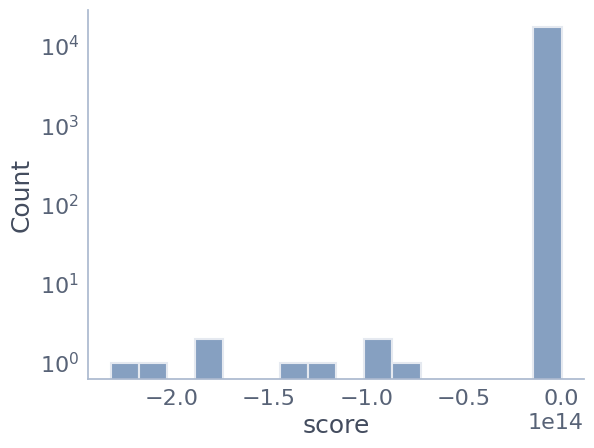

In [15]:
sns.histplot(scores_largest_alpha)
plt.yscale('log')

# Repeat for lower alpha Range

In [16]:
alpha_range = np.logspace(-5, 20, 26)
alpha_range

array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10,
       1.e+11, 1.e+12, 1.e+13, 1.e+14, 1.e+15, 1.e+16, 1.e+17, 1.e+18,
       1.e+19, 1.e+20])

In [17]:
path = result_path(subject, modality, "ridge", "alpha", alpha_range)

In [18]:
if not os.path.exists(path):
    print("File does not exist")
    delayer = Delayer(delays=range(1, number_of_delays + 1))

    solver_params = dict(
        n_targets_batch=n_targets_batch,
        n_targets_batch_refit=n_targets_batch_refit,
        n_alphas_batch=n_alphas_batch,
        score_func=himalaya.scoring.r2_score
    )
    ridge_cv = RidgeCV(alphas=alpha_range, cv=cv, solver_params=solver_params)
    pipeline = make_pipeline(
        delayer,
        ridge_cv
    )

    pipeline.fit(X[:n_samples_train], Y[:n_samples_train])

    score = pipeline.score(X[n_samples_train:], Y[n_samples_train:])

    best_alphas = pd.DataFrame(
        {
            'best_alphas': backend.to_numpy(pipeline[-1].best_alphas_),
            'score': backend.to_numpy(score)
        }
    )
    best_alphas.to_csv(path)
else:
    print("File exists")
    best_alphas = pd.read_csv(path)

File exists


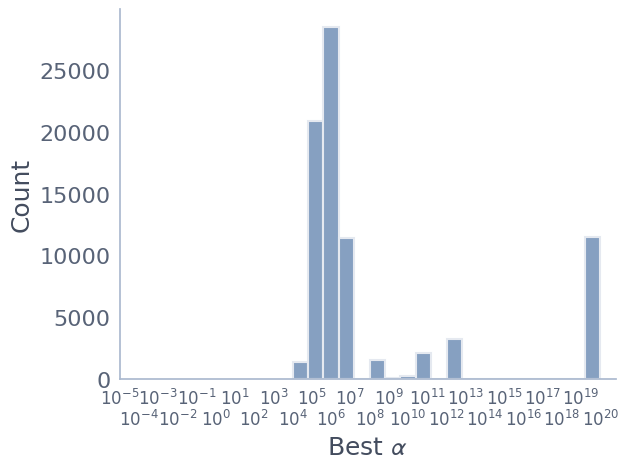

In [23]:
fig, ax = plt.subplots()
sns.histplot(best_alphas['best_alphas'], bins=20, log_scale=True, ax=ax)
plt.xlabel(r"Best $\alpha$")
plt.xticks(alpha_range)
labels_formatted = [label.get_text() if i % 2 == 0 else '\n' + label.get_text() for i, label in
                    enumerate(ax.xaxis.get_majorticklabels())]
plt.xticks(alpha_range, labels=labels_formatted, fontsize=12)
plt.show()

In [20]:
f"{best_alphas['score'].min():.2e}"

'-3.06e+14'

In [21]:
# plot scores for voxels with largest alpha
scores_largest_alpha = pd.DataFrame(best_alphas[best_alphas['best_alphas'] == 9.999987e+19]['score'])
scores_largest_alpha

,score
4,0.000000e+00
5,-2.958785e+14
6,0.000000e+00
7,0.000000e+00
8,-2.440184e+14
...,...
81127,0.000000e+00
81128,0.000000e+00
81130,0.000000e+00
81131,-1.792125e+14


Text(0.5, 0, 'r2 score for largest alphas')

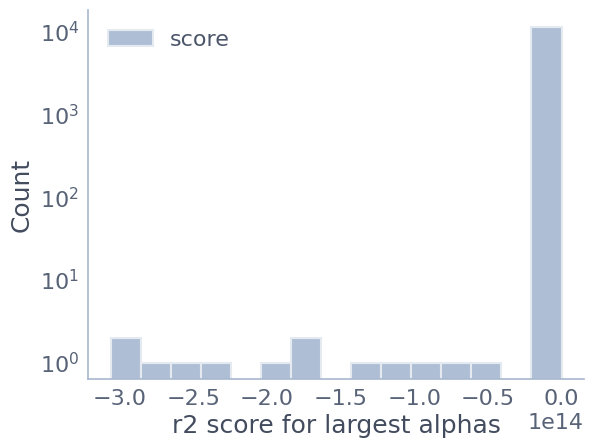

In [24]:
# log scale y axis
sns.histplot(scores_largest_alpha)
plt.yscale('log')
plt.xlabel('r2 score for largest alphas')